In [61]:
%matplotlib inline

In [62]:
import os
import gc
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import plotnine
from plotnine import *
import matplotlib.pyplot as plt
from mizani.formatters import comma_format

In [78]:
data_dir_root = os.path.abspath('/efs/liam/tb-gene-signature-datasets/network-analysis')
original_dir = os.path.join(data_dir_root, 'Biomarkers Project Packaged', 'Data')
reproduce_dir = os.path.join(data_dir_root, 'reproduce', 'Data')
reproduce_orig_dir = os.path.join(data_dir_root, 'reproduce-original-diff-exp', 'Data')
convert_dir = os.path.join(data_dir_root, 'convert-to-scripts')
nolog_dir = os.path.join(data_dir_root, 'reproduce-no-log', 'Data')

## Comparison of original and reproduced network analysis output

### ATB vs. HC

In [79]:
datasets = [
    ('GSE41055', 'gene_assignment', 'microarray'),
    ('GSE29536', 'Gene.symbol', 'microarray'),
    ('GSE42830', 'Gene.symbol', 'microarray'),
    ('GSE54992', 'Gene.symbol', 'microarray'),
    ('GSE34608', 'Gene.symbol', 'microarray'),
    ('GSE42825', 'Gene.symbol', 'microarray'),
    ('GSE28623', 'Gene.symbol', 'microarray'),
    ('GSE62525', 'Gene_symbol', 'microarray'),
    ('GSE56153', 'Gene.symbol', 'microarray'),
    ('GSE19439', 'Gene.symbol', 'microarray'),
    ('GSE83456', 'Gene.symbol', 'microarray'),
    ('GSE42826', 'Gene.symbol', 'microarray'),
    ('GSE19444', 'Gene.symbol', 'microarray'),
    ('GSE84076', 'genes', 'RNAseq'),
    ('GSE107994', 'genes', 'RNAseq')
]

#### Normalized expression datasets

In [80]:
def load_normalized_expression_datasets(gse_id, comparison, dataset_type, n_rows):
    df_original = pd.read_csv(
        os.path.join(
            original_dir, 'Normalized Expression Data',
            comparison, f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))

    df_reproduce = pd.read_csv(
        os.path.join(
            reproduce_dir, 'Normalized Expression Data',
            comparison, f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))
    
    df_nolog = pd.read_csv(
        os.path.join(
            nolog_dir, 'Normalized Expression Data',
            comparison, f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))

    df_original = df_original.drop('Unnamed: 0', axis=1)
    df_reproduce = df_reproduce.drop('Unnamed: 0', axis=1)
    df_nolog = df_nolog.drop('Unnamed: 0', axis=1)

    df_original = df_original.melt(
        var_name='gene_name',
        value_name='original_val')
    
    df_reproduce = df_reproduce.melt(
        var_name='gene_name',
        value_name='reproduce_val')
    
    df_nolog = df_nolog.melt(
        var_name='gene_name',
        value_name='nolog_val')

    df = (
        df_original
        #.merge(df_reproduce, on='gene_name')
        .merge(df_nolog, on='gene_name')
    )
    
    df = df.sample(n_rows)
    df['dataset'] = gse_id
    
    return df

In [74]:
microarray_normalized = pd.concat([
    load_normalized_expression_datasets(dataset[0], 'ATB_HC', dataset[2], 10000)
    for dataset in datasets if dataset[2] == 'microarray'])

In [75]:
microarray_corrs = (
    microarray_normalized
    .groupby('dataset')
    .apply(
        lambda x: x[['original_val', 'nolog_val']].corr(method='pearson').iloc[0,1])
    .reset_index()
    .rename({0: 'corr'}, axis=1))
microarray_corrs['corr'] = microarray_corrs['corr'].apply(lambda x: f'$\\rho = {round(x, 3)}$')

/shared/software/anaconda3/envs/bio-core/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 14255 rows containing missing values.


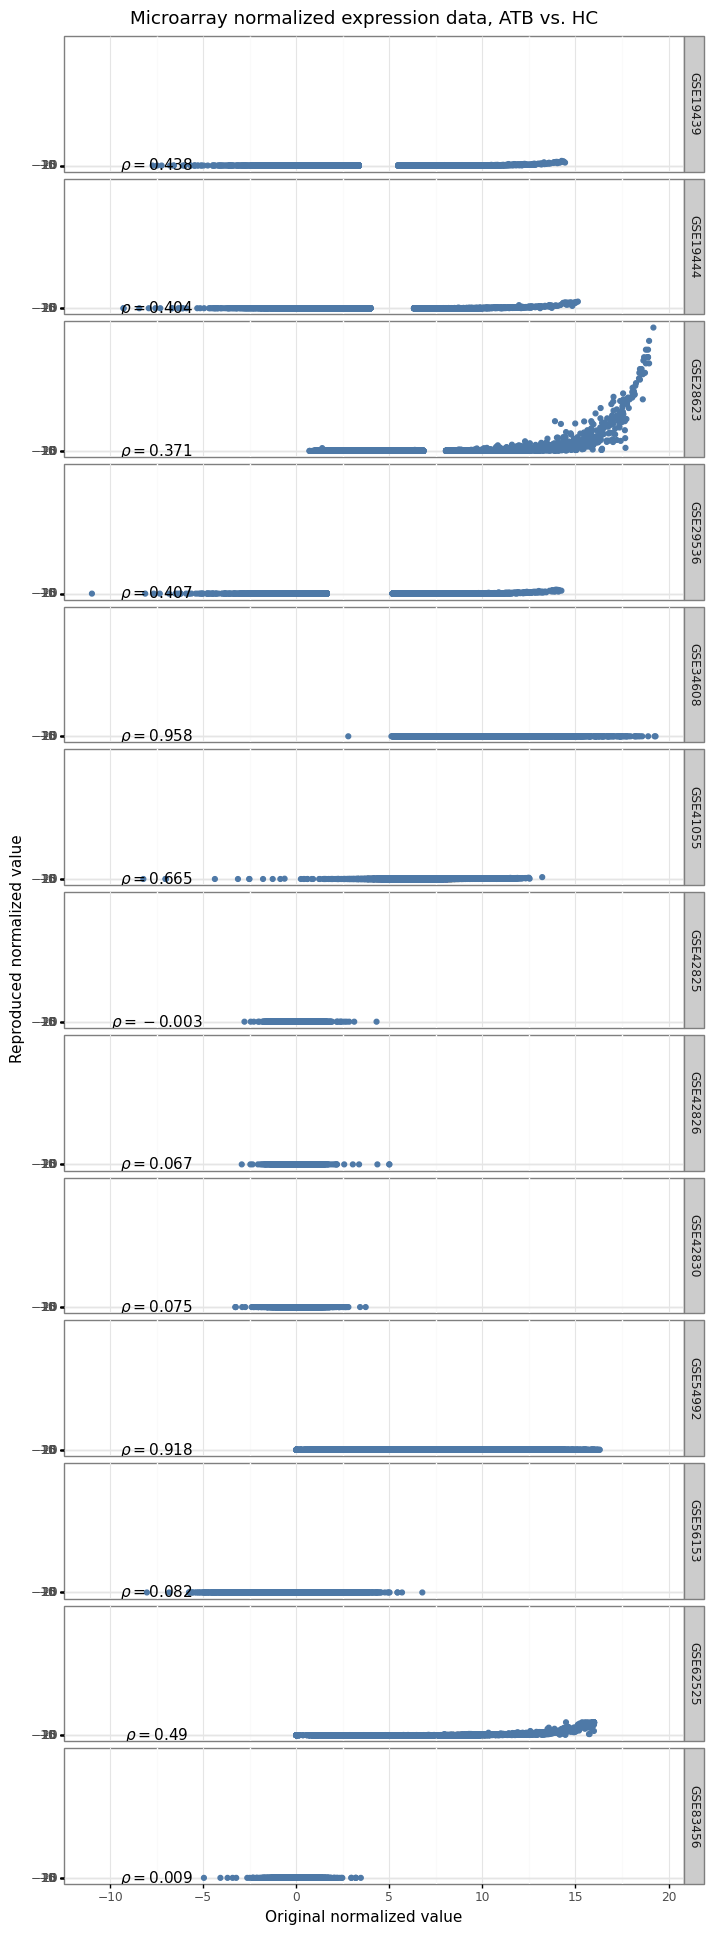

In [76]:
plotnine.options.figure_size = (8, 24)
p = (
    ggplot(
        microarray_normalized) +
    geom_point(
        aes(x='original_val',
            y='nolog_val'),
        color='#4E79A7') +
    geom_text(
        microarray_corrs,
        aes(x=-7.5, y=15, label='corr')) +
    facet_grid(
        'dataset ~ .') +
    scale_x_continuous(
        breaks=np.arange(-10, 21, 5)) +
    scale_y_continuous(
        breaks=np.arange(-10, 21, 5)) +
    labs(
        x='Original normalized value',
        y='Reproduced normalized value',
        title='Microarray normalized expression data, ATB vs. HC') +
    theme_bw()
)
p.draw();

In [77]:
microarray_normalized

,gene_name,original_val,nolog_val,dataset
3459600,NM_032859 // ABHD13 // abhydrolase domain cont...,9.069997,630.081768,GSE41055
1082367,NM_198722 // AMIGO3 // adhesion molecule with ...,7.773640,211.157713,GSE41055
2927658,"NM_000073 // CD3G // CD3g molecule, gamma (CD3...",9.496250,2606.497001,GSE41055
2263205,"NM_000837 // GRINA // glutamate receptor, iono...",10.236717,2779.181943,GSE41055
614845,NM_017623 // CNNM3 // cyclin M3 // 2p12-p11.2 ...,8.433728,435.832050,GSE41055
...,...,...,...,...
7884420,SBK1,6.922927,285.248864,GSE19444
2897830,ARHGAP33,6.444135,61.055595,GSE19444
5911745,NR1H4,NaN,8.468043,GSE19444
5534400,RPS6KB1,7.485227,179.706345,GSE19444


In [32]:
rnaseq_normalized = pd.concat([
    load_normalized_expression_datasets(dataset[0], 'ATB_HC', dataset[2], 10000)
    for dataset in datasets if dataset[2] == 'RNAseq'])

In [33]:
rnaseq_corrs = (
    rnaseq_normalized
    .groupby('dataset')
    .apply(
        lambda x: x[['original_val', 'reproduce_val']].corr(method='pearson').iloc[0,1])
    .reset_index()
    .rename({0: 'corr'}, axis=1))
rnaseq_corrs['corr'] = rnaseq_corrs['corr'].apply(lambda x: f'$\\rho = {round(x, 3)}$')

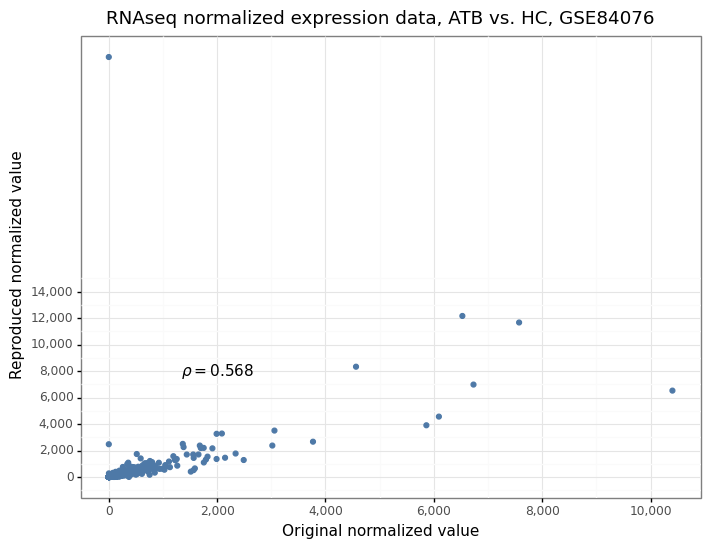

In [34]:
plotnine.options.figure_size = (8, 6)
p = (
    ggplot(
        rnaseq_normalized.loc[
            rnaseq_normalized['dataset'] == 'GSE84076']) +
    geom_point(
        aes(x='original_val',
            y='reproduce_val'),
        color='#4E79A7') +
    annotate(
        'text', x=2000, y=8000,
        label=rnaseq_corrs.loc[
            rnaseq_corrs['dataset'] == 'GSE84076', 'corr'].values[0]) +
    scale_x_continuous(
        breaks=np.arange(0, 15000, 2000),
        labels=comma_format()) +
    scale_y_continuous(
        breaks=np.arange(0, 15000, 2000),
        labels=comma_format()) +
    labs(
        x='Original normalized value',
        y='Reproduced normalized value',
        title='RNAseq normalized expression data, ATB vs. HC, GSE84076') +
    theme_bw()
)
p.draw();

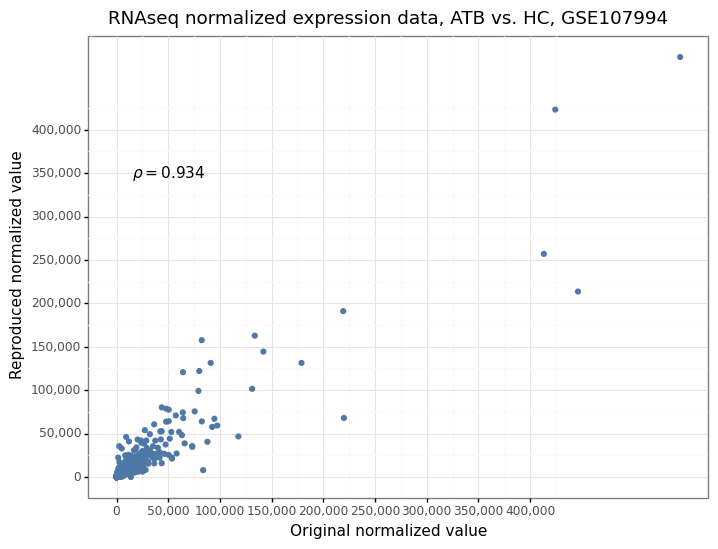

In [35]:
plotnine.options.figure_size = (8, 6)
p = (
    ggplot(
        rnaseq_normalized.loc[
            rnaseq_normalized['dataset'] == 'GSE107994']) +
    geom_point(
        aes(x='original_val',
            y='reproduce_val'),
        color='#4E79A7') +
    annotate(
        'text', x=50000, y=350000,
        label=rnaseq_corrs.loc[
            rnaseq_corrs['dataset'] == 'GSE107994', 'corr'].values[0]) +
    scale_x_continuous(
        breaks=np.arange(0, 450000, 50000),
        labels=comma_format()) +
    scale_y_continuous(
        breaks=np.arange(0, 450000, 50000),
        labels=comma_format()) +
    labs(
        x='Original normalized value',
        y='Reproduced normalized value',
        title='RNAseq normalized expression data, ATB vs. HC, GSE107994') +
    theme_bw()
)
p.draw();

#### Differential expression datasets

In [90]:
def load_differential_expression_datasets(gse_id, gene_col_name, comparison, dataset_type):
    group1, group0 = [x.lower() for x in comparison.split('_v_')]
    
    if dataset_type == 'microarray':
        df_original = pd.read_csv(
            os.path.join(original_dir, 'Microarray Differential Gene Expression',
                         comparison, f'{gse_id}.csv'))
        
        df_reproduce = pd.read_csv(
            os.path.join(reproduce_dir, 'Microarray Differential Gene Expression',
                         comparison, f'{gse_id}.csv'))
        
        df_nolog = pd.read_csv(
            os.path.join(nolog_dir, 'Microarray Differential Gene Expression',
                         comparison, f'{gse_id}.csv'))

    elif dataset_type == 'RNAseq':
        df_original = pd.read_csv(
            os.path.join(original_dir, 'RNAseq Differential Gene Expression',
                         comparison, f'{gse_id}.csv'))
        
        df_reproduce = pd.read_csv(
            os.path.join(reproduce_dir, 'RNAseq Differential Gene Expression',
                         comparison, f'{gse_id}.csv'))
        
        df_nolog = pd.read_csv(
            os.path.join(nolog_dir, 'RNAseq Differential Gene Expression',
                         comparison, f'{gse_id}.csv'))
    
    df_convert = pd.read_table(
            os.path.join(convert_dir, 'differential-expression-analysis',
                         f'{gse_id}.{group0}_vs_{group1}.differential_expression_results.tsv'), sep='\t')

    df_original = df_original[[gene_col_name, 'logFC']].rename({
        gene_col_name: 'gene_name', 'logFC': 'original_logFC'}, axis=1)
    df_reproduce = df_reproduce[[gene_col_name, 'logFC']].rename({
        gene_col_name: 'gene_name', 'logFC': 'reproduce_logFC'}, axis=1)
    df_nolog = df_nolog[[gene_col_name, 'logFC']].rename({
        gene_col_name: 'gene_name', 'logFC': 'nolog_logFC'}, axis=1)
    df_convert = df_convert[['gene_symbol', 'logFC']].rename({
        'gene_symbol': 'gene_name', 'logFC': 'convert_logFC'}, axis=1)

    df = (
        df_original
        .merge(df_reproduce, on='gene_name')
        .merge(df_nolog, on='gene_name')
        .merge(df_convert, on='gene_name')
    )
    df['dataset'] = gse_id
    
    return df

In [91]:
differential_expressions = pd.concat([
    load_differential_expression_datasets(
        dataset[0], dataset[1], 'ATB_v_HC', dataset[2]) for dataset in datasets])

/shared/software/anaconda3/envs/bio-core/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 24294 rows containing missing values.


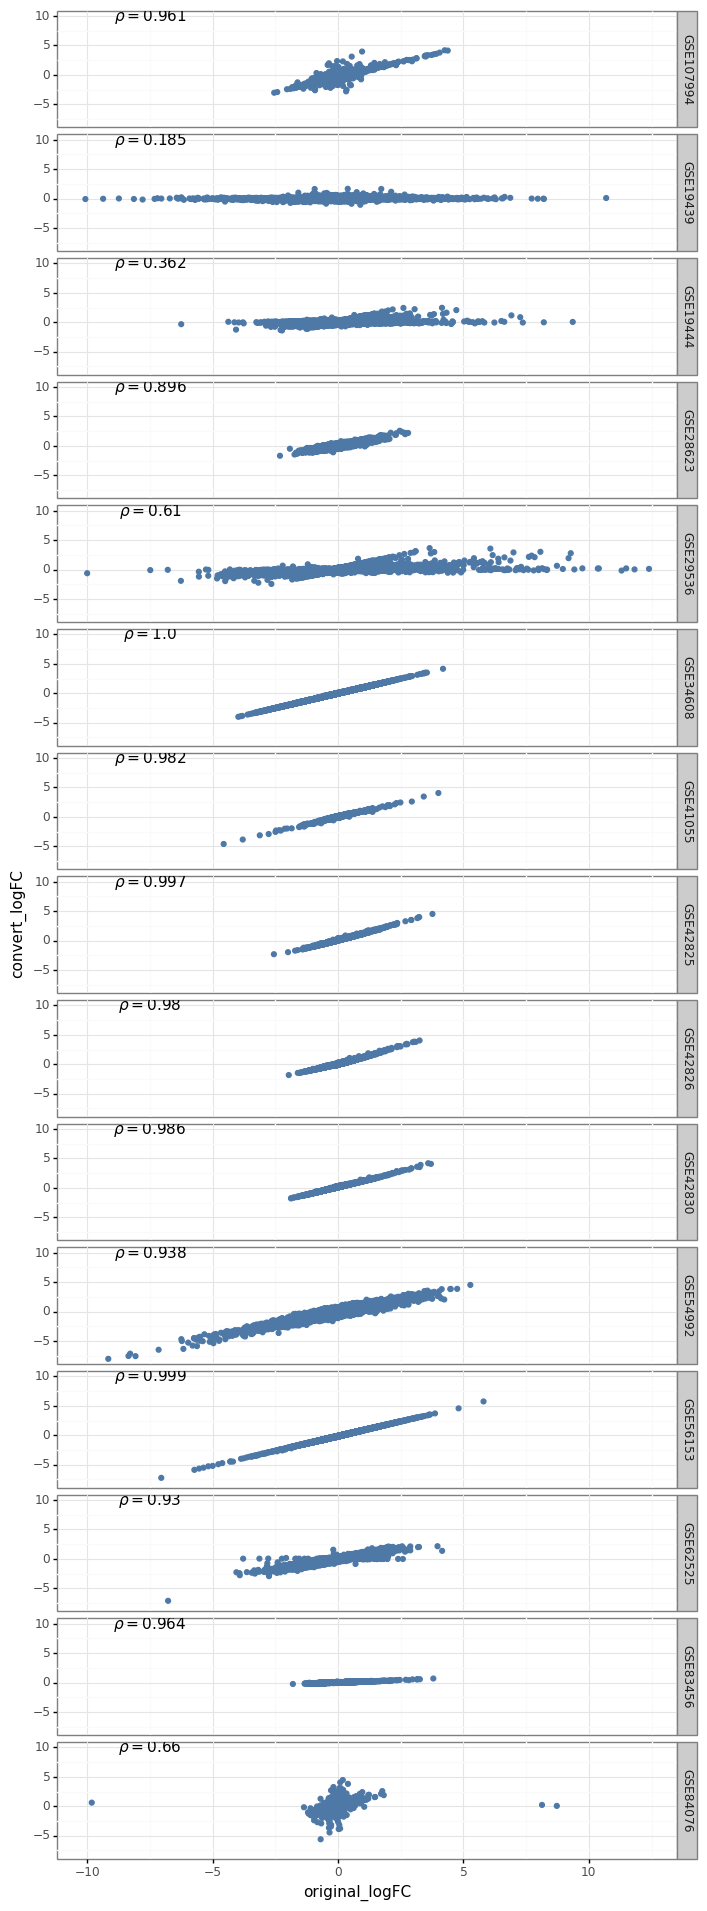

In [95]:
plotnine.options.figure_size = (8, 24)

compare = 'convert'

differential_expressions_corrs = (
    differential_expressions
    .groupby('dataset')
    .apply(lambda x: x[['original_logFC', f'{compare}_logFC']].corr(method='pearson').iloc[0,1])
    .reset_index()
    .rename({0: 'corr'}, axis=1))

differential_expressions_corrs['corr'] = (
    differential_expressions_corrs['corr'].apply(lambda x: f'$\\rho = {round(x, 3)}$'))

p = (
    ggplot(
        differential_expressions) +
    geom_point(
        aes(x='original_logFC',
            y=f'{compare}_logFC'),
        color='#4E79A7') +
    geom_text(
        differential_expressions_corrs,
        aes(x=-7.5,
            y=10,
            label='corr')) +
    facet_grid(
        'dataset ~ .') +
    theme_bw()
)
p.draw();

#### Pooled differential expression

In [114]:
pooled_original = pd.read_csv(
    os.path.join(original_dir, 'Pooled Differential Gene Expression', 
                 'ATB_v_HC_signif_logFC_qval_thresh_0.05.csv'))
pooled_original = (
    pooled_original
    .rename({'Unnamed: 0': 'gene_name'}, axis=1)
    .melt(
        id_vars='gene_name',
        var_name='dataset',
        value_name='original_pooled'))

In [121]:
pooled_reproduce = pd.read_csv(
    os.path.join(reproduce_dir, 'Pooled Differential Gene Expression',
                 'ATB_v_HC_signif_logFC_qval_thresh_0.05.csv'))
pooled_reproduce = (
    pooled_reproduce
    .rename({'Unnamed: 0': 'gene_name'}, axis=1)
    .melt(
        id_vars='gene_name',
        var_name='dataset',
        value_name='reproduce_pooled'))

In [122]:
pooled = pd.merge(
    pooled_original, pooled_reproduce, on=['gene_name', 'dataset'])

In [130]:
pooled_corrs = (
    pooled
    .groupby('dataset')
    .apply(lambda x: x[['original_pooled', 'reproduce_pooled']].corr().iloc[0,1])
    .reset_index()
    .rename({0: 'corr'}, axis=1))
pooled_corrs['corr'] = pooled_corrs['corr'].apply(lambda x: f'$\\rho = {round(x, 3)}$')

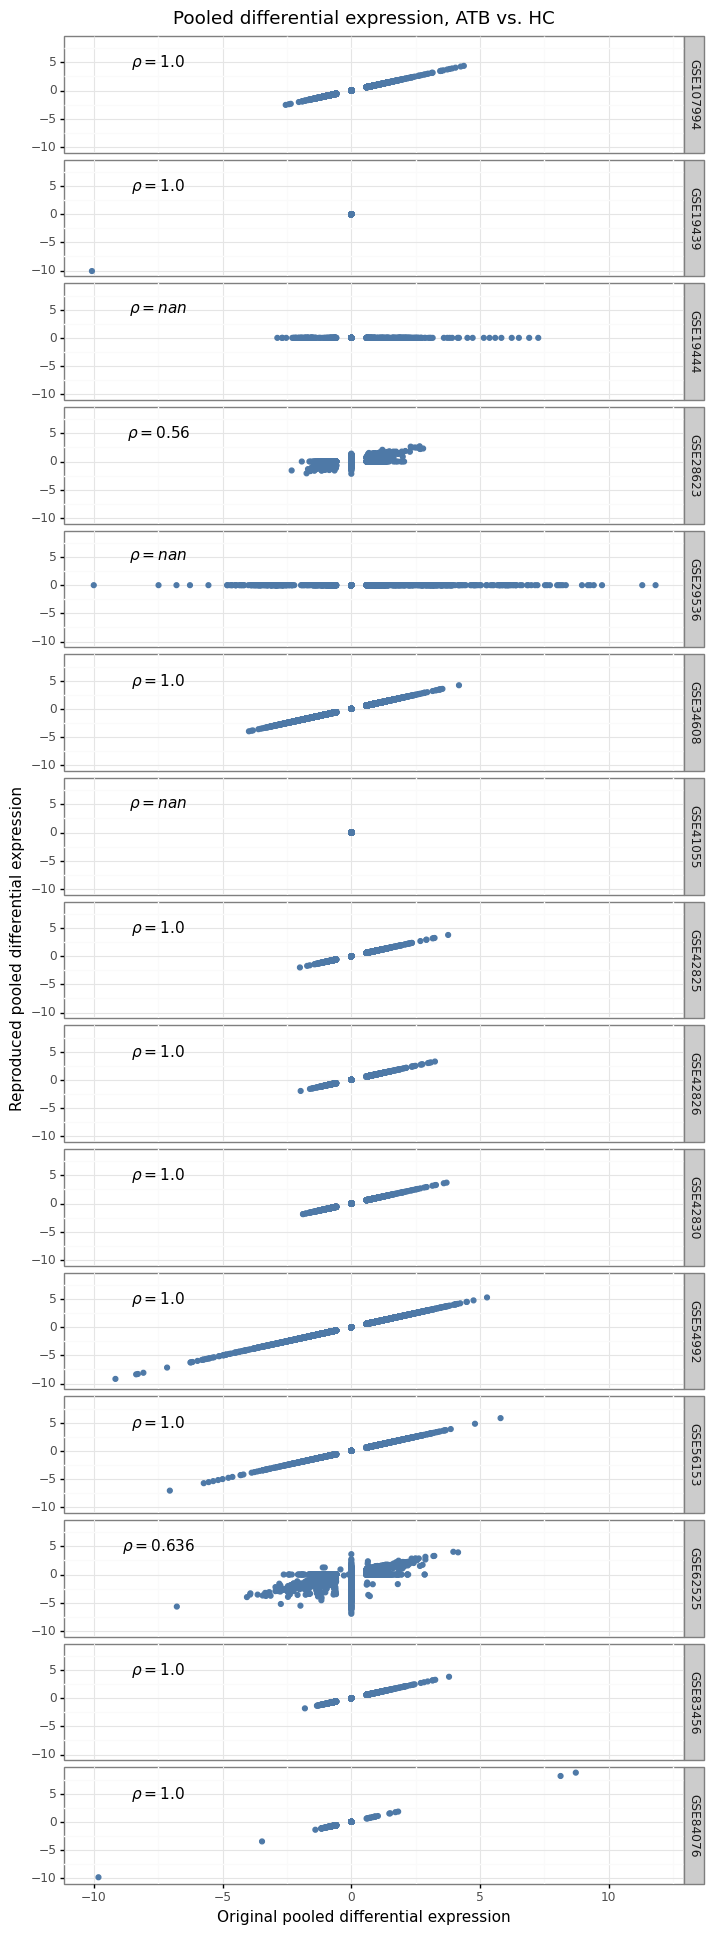

In [133]:
plotnine.options.figure_size = (8, 24)
p = (
    ggplot(
        pooled) +
    geom_point(
        aes(x='original_pooled',
            y='reproduce_pooled'),
        color='#4E79A7') +
    geom_text(
        pooled_corrs,
        aes(x=-7.5, y=5, label='corr')) +
    facet_grid(
        'dataset ~ .') +
    labs(
        x='Original pooled differential expression',
        y='Reproduced pooled differential expression',
        title='Pooled differential expression, ATB vs. HC') +
    theme_bw()
)
p.draw();

#### Pooled differential expression with original differential expression results

In [137]:
pooled_reproduce_orig = pd.read_csv(
    os.path.join(reproduce_orig_dir, 'Pooled Differential Gene Expression',
                 'ATB_v_HC_signif_logFC_qval_thresh_0.05.csv'))
pooled_reproduce_orig = (
    pooled_reproduce_orig
    .rename({'Unnamed: 0': 'gene_name'}, axis=1)
    .melt(
        id_vars='gene_name',
        var_name='dataset',
        value_name='reproduce_orig_pooled'))

In [139]:
pooled_orig = pd.merge(
    pooled_original, pooled_reproduce_orig, on=['gene_name', 'dataset'])

In [141]:
pooled_orig_corrs = (
    pooled_orig
    .groupby('dataset')
    .apply(lambda x: x[['original_pooled', 'reproduce_orig_pooled']].corr().iloc[0,1])
    .reset_index()
    .rename({0: 'corr'}, axis=1))
pooled_orig_corrs['corr'] = pooled_orig_corrs['corr'].apply(lambda x: f'$\\rho = {round(x, 3)}$')

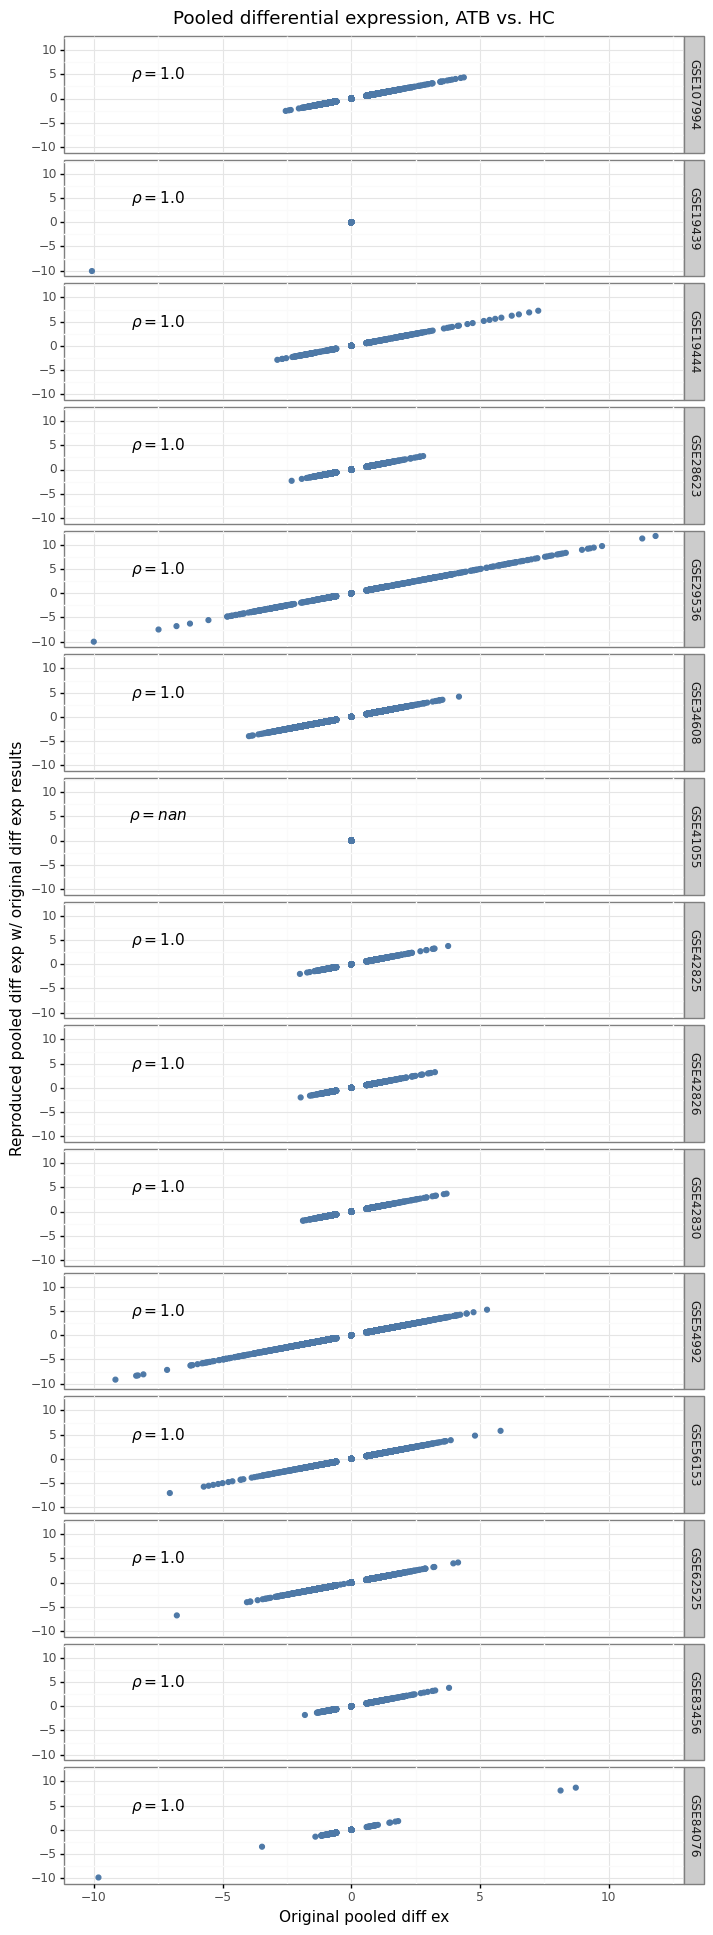

In [142]:
plotnine.options.figure_size = (8, 24)
p = (
    ggplot(
        pooled_orig) +
    geom_point(
        aes(x='original_pooled',
            y='reproduce_orig_pooled'),
        color='#4E79A7') +
    geom_text(
        pooled_orig_corrs,
        aes(x=-7.5, y=5, label='corr')) +
    facet_grid(
        'dataset ~ .') +
    labs(
        x='Original pooled diff ex',
        y='Reproduced pooled diff exp w/ original diff exp results',
        title='Pooled differential expression, ATB vs. HC') +
    theme_bw()
)
p.draw();

In [ ]:
df_original.iloc[:5,:5]

In [ ]:
df_notebooks.iloc[:5,:5]

In [ ]:
df_new.iloc[:5,:5]

In [ ]:
microarray_normalized_expression = {
    'original': 
}

In [ ]:
with open('/efs/liam/tb-gene-signature-datasets/network-analysis/original/Pickled Files/Network Files/weighted degree series/ATB_v_HC.pkl', 'rb') as f:
    original = pd.DataFrame(pickle.load(f), columns=['original'])

In [ ]:
with open('/efs/liam/tb-gene-signature-datasets/network-analysis/notebooks/pickled-files/Network Files/weighted degree series/ATB_v_HC.pkl', 'rb') as f:
    reproduced = pd.DataFrame(pickle.load(f), columns=['reproduced'])

In [ ]:
joined = pd.merge(original, reproduced, how='outer', left_index=True, right_index=True)

In [ ]:
joined_filtered = joined.dropna()

In [ ]:
corr = joined_filtered.corr(method='spearman').iloc[0,1]

In [ ]:
p = (
    ggplot(joined_filtered) +
    geom_point(
        aes(x='original',
            y='reproduced'),
        color='#4E79A7') +
    annotate(
        'text', x=100, y=400,
        label=f'$\\rho_{{spearman}} = {round(corr, 3)}$') +
    labs(
        x='Roger\'s weighted degrees',
        y='Reproduced weighted degrees',
        title='ATB v HC network nodes') +
    theme_bw()
)
p.draw();
p.save('/shared/liam.abbott/downloads/atb-hc-network-comparison.pdf')

In [ ]:
with open('/efs/liam/tb-gene-signature-datasets/network-analysis/original/Pickled Files/Network Files/networks/ATB_v_HC.pkl', 'rb') as f:
    g = pickle.load(f)
    i = []
    j = []
    w = []
    for line in nx.generate_edgelist(g):
        split = line.split()
        i.append(split[0])
        j.append(split[1])
        w.append(float(split[3].replace('}', ''))*15)
    original = pd.DataFrame({'i': i, 'j': j, 'original': w})

In [ ]:
with open('/efs/liam/tb-gene-signature-datasets/network-analysis/notebooks/Data/Pickled Files/Network Files/networks/ATB_v_HC.pkl', 'rb') as f:
    g = pickle.load(f)
    i = []
    j = []
    w = []
    for line in nx.generate_edgelist(g):
        split = line.split()
        i.append(split[0])
        j.append(split[1])
        w.append(float(split[3].replace('}', ''))*15)
    reproduced = pd.DataFrame({'i': i, 'j': j, 'reproduced': w})

In [ ]:
edge_weights = pd.merge(original, reproduced, left_on=['i', 'j'], right_on=['i', 'j'], how='inner')

In [ ]:
corr = edge_weights[['original', 'reproduced']].corr(method='spearman').iloc[0,1]

In [ ]:
corr

In [ ]:
p = (
    ggplot(edge_weights) +
    geom_point(
        aes(x='original',
            y='reproduced'),
        color='#4E79A7') +
    labs(
        x='Roger\'s data',
        y='Reproduced data',
        title='ATB v HC network edge weights') +
    scale_x_continuous(
        breaks=np.arange(0, 16, 2)) +
    scale_y_continuous(
        breaks=np.arange(0, 16, 2)) +
    coord_cartesian(
        xlim=[0,16], ylim=[0,16]) +
    theme_bw()
)
p.draw();
p.save('/shared/liam.abbott/downloads/atb-hc-edge-weight-comparison.pdf')

In [ ]:
df = pd.DataFrame({'i': i, 'j': j, 'w': w})

In [ ]:
df

In [ ]:
os.listdir('/efs/liam/tb-gene-signature-datasets/network-analysis/original/RNAseq Differential Gene Expression/ATB_v_HC/')

In [ ]:
datasets = [
    ('GSE41055', 'gene_assignment', 'microarray'),
    ('GSE29536', 'Gene.symbol', 'microarray'),
    ('GSE42830', 'Gene.symbol', 'microarray'),
    ('GSE54992', 'Gene.symbol', 'microarray'),
    ('GSE34608', 'Gene.symbol', 'microarray'),
    ('GSE42825', 'Gene.symbol', 'microarray'),
    ('GSE28623', 'Gene.symbol', 'microarray'),
    ('GSE62525', 'Gene_symbol', 'microarray'),
    ('GSE56153', 'Gene.symbol', 'microarray'),
    ('GSE19439', 'Gene.symbol', 'microarray'),
    ('GSE83456', 'Gene.symbol', 'microarray'),
    ('GSE42826', 'Gene.symbol', 'microarray'),
    ('GSE19444', 'Gene.symbol', 'microarray'),
    ('GSE84076', 'genes', 'rnaseq'),
    ('GSE107994', 'genes', 'rnaseq')
]

In [ ]:
def load_results(gse_id, gene_col_name, comparison, dataset_type):
    group0, group1 = comparison.split('-')
    root = os.path.abspath('/efs/liam/tb-gene-signature-datasets/network-analysis/')
    
    if dataset_type == 'microarray':
        old = pd.read_csv(os.path.join(root, 'original', 'Microarray Differential Gene Expression', f'{group0.upper()}_v_{group1.upper()}', f'{gse_id}.csv'))
        new = pd.read_csv(os.path.join(root, 'notebooks', 'microarray-differential-gene-expression', comparison, f'{gse_id}.csv'))

    elif dataset_type == 'rnaseq':
        old = pd.read_csv(os.path.join(root, 'original', 'RNAseq Differential Gene Expression', f'{group0.upper()}_v_{group1.upper()}', f'{gse_id}.csv'))
        new = pd.read_csv(os.path.join(root, 'notebooks', 'rna-seq-differential-gene-expression', comparison, f'{gse_id}.csv'))

    old = old[[gene_col_name, 'logFC']].rename({gene_col_name: 'gene_name', 'logFC': 'logFC_roger'}, axis=1)
    new = new[[gene_col_name, 'logFC']].rename({gene_col_name: 'gene_name', 'logFC': 'logFC_reproduced'}, axis=1)
    
    df = pd.merge(old, new, on='gene_name').assign(dataset=gse_id)
    
    return df

In [ ]:
df = pd.concat([load_results(
    gse_id=x[0], gene_col_name=x[1], comparison='atb-hc', dataset_type=x[2]) for x in datasets])

In [ ]:
df

In [ ]:
df.logFC_roger.isnull().sum()

In [ ]:
df.logFC_reproduced.isnull().sum()

In [ ]:
df

In [ ]:
corrs = (
    df
    .groupby('dataset')
    .apply(lambda x: round(x.corr(method='pearson').iloc[0,1], 3))
    .reset_index()
    .rename({0: 'corr'}, axis=1)
)

In [ ]:
corrs['label'] = corrs['corr'].apply(lambda x: f'$\\rho = {x}$')

In [ ]:
plotnine.options.figure_size = (8, 16)
p = (
    ggplot(df) +
    geom_point(
        aes(x='logFC_roger',
            y='logFC_reproduced'),
        color='#4E79A7') +
    geom_text(corrs, aes(x=-7.5, y=10, label='label')) +
    facet_grid(
        'dataset ~ .') +
    theme_bw()
)
p.draw();
p.save('/shared/liam.abbott/downloads/atb-hc-logFC-comparison.png', height=16, width=8)

In [ ]:
def load_normalized_datasets(gse_id, comparison, dataset_type):
    group0, group1 = comparison.split('-')
    if dataset_type == 'rnaseq':
        dataset_type = 'RNAseq'
    root = os.path.abspath('/efs/liam/tb-gene-signature-datasets/network-analysis/')

    old = pd.read_csv(os.path.join(root, 'original', 'Normalized Expression Data', f'{group0.upper()}_{group1.upper()}', f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))
    new = pd.read_csv(os.path.join(root, 'notebooks', 'normalized-expression-data', comparison, f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))
    
    old = old.drop('Unnamed: 0', axis=1)
    new = new.drop('Unnamed: 0', axis=1)
        
    old = old.melt(
        var_name='gene_name',
        value_name='roger_val')
    
    new = new.melt(
        var_name='gene_name',
        value_name='reproduced_val')

    df = pd.merge(old, new, on='gene_name').assign(dataset=gse_id)
    
    return df

In [ ]:
gse_id = 'GSE41055'
comparison = 'atb-hc'
group0, group1 = comparison.split('-')
dataset_type = 'microarray'
if dataset_type == 'rnaseq':
    dataset_type = 'RNAseq'
root = os.path.abspath('/efs/liam/tb-gene-signature-datasets/network-analysis/')
old = pd.read_csv(os.path.join(root, 'original', 'Normalized Expression Data', f'{group0.upper()}_{group1.upper()}', f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))
new = pd.read_csv(os.path.join(root, 'notebooks', 'normalized-expression-data', comparison, f'{gse_id}_{dataset_type}_Exp_EachGene.csv'))

In [ ]:
df_normalized = pd.concat([
    load_normalized_datasets(x[0], comparison='atb-hc', dataset_type=x[2]) for x in datasets])

In [ ]:
normalized_corrs = (
    df_normalized
    .groupby('dataset')
    .apply(lambda x: round(x.corr(method='pearson').iloc[0,1], 3))
    .reset_index()
    .rename({0: 'corr'}, axis=1)
)

In [ ]:
datasets

In [ ]:
(
    ggplot(df) +
    geom_point(
        aes(x='roger_val',
            y='reproduced_val'),
        color='#4E79A7') +
    labs(x='Roger normalized value',
         y='Reproduced normalized value',
         title=f'{dataset[0]}, {label}') +
    theme_bw()
).draw();

In [ ]:
for dataset in datasets:
    df = load_normalized_datasets(dataset[0], comparison='atb-hc', dataset_type=dataset[2])
    corr = df[['roger_val', 'reproduced_val']].corr(method='pearson').iloc[0,1]
    #label = f'$\rho_{{pearson}} = {round(corr, 3)}'
    print(dataset[0], corr)
    """
    (
        ggplot(df) +
        geom_point(
            aes(x='roger_val',
                y='reproduced_val'),
            color='#4E79A7') +
        labs(x='Roger normalized value',
             y='Reproduced normalized value',
             title=f'{dataset[0]}, {label}') +
        theme_bw()
    ).save(f'/shared/liam.abbott/downloads/atb-hc-normalized-values-comparison.{dataset[0]}.png', dpi=100)
    """

In [ ]:
normalized_corrs['label'] = normalized_corrs['corr'].apply(lambda x: f'$\\rho = {x}$')

In [ ]:
plotnine.options.figure_size = (8, 16)

In [ ]:
df_normalized

In [ ]:
df_normalized

In [ ]:
for dataset in datasets:
    if dataset[0] == 'GSE41055':
        continue
    df_ = df_normalized.loc[
        df_normalized['dataset'] == dataset[0], :]
    corr_ = normalized_corrs.loc[
        normalized_corrs['dataset'] == dataset[0], 'label']
    print(df_.iloc[:5,:5])
    """
    p = (
        ggplot(df_) +
        geom_point(
            aes(x='roger_val',
                y='reproduced_val'),
            color='#4E79A7') +
        labs(x='Roger normalized value',
             y='Reproduced normalized value',
             title=f'{dataset}, {corr_}') +
        theme_bw()
    )
    """
    p.draw();
    p.save(f'/shared/liam.abbott/downloads/atb-hc-normalized-values-comparison.{dataset}.png', height=16, width=8)